### Imports

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from gurobipy import Model, GRB, quicksum
import numpy as np
import math
import sys
import geopandas as gpd
import matplotlib.pyplot as plt

### Load data

#### Model data

In [25]:
county_or_tract = 'tract' # 'tract' or 'county'
state = 'AK' # 'RI', 'WA', 'AR', 'AK'

distance_data = 'data/{}/{}_distances.csv'.format(state, county_or_tract)
population_data = 'data/{}/{}_population.txt'.format(state, county_or_tract)
features_data = 'data/{}/{}_features.csv'.format(state, county_or_tract)

In [26]:
dist_df = pd.read_csv(distance_data)
with open(population_data) as f:
    pop = f.read().splitlines()

pop_df = []
for p in pop[1:]:
    pop_df.append(p.split(' '))
pop_df = pd.DataFrame(pop_df, columns=["id", "pop"])

feature_df = pd.read_csv(features_data, header=None)

#### Vis data

In [27]:
if county_or_tract == 'county':
    path_to_shapefile = '{}_geo_files/{}/{}_counties'.format(state, county_or_tract, state)
    path_to_centers_shapefile = '{}_geo_files/{}/{}_centers'.format(state, county_or_tract, state)
else:
    path_to_shapefile = '{}_geo_files/{}/{}_tracts'.format(state, county_or_tract, state)
    path_to_centers_shapefile = '{}_geo_files/{}/{}_centers'.format(state, county_or_tract, state)

### Preprocessing

In [28]:
zero_matrix = np.zeros((len(feature_df), len(feature_df)))
adj_df = pd.DataFrame(zero_matrix)
id_map = {}
for i, id in enumerate(feature_df[0]):
    id_map[id] = i

In [29]:
for node, adj_list in zip(feature_df[0], feature_df[2]):
    node_idx = id_map[node]
    for adj in adj_list.split(','):
        adj_idx = id_map[int(adj[1:])]
        adj_df.iloc[node_idx, adj_idx] = 1
adj_matrix = adj_df.values

In [30]:
pop_df['pop'] = pd.to_numeric(pop_df['pop'], errors='coerce')

In [31]:
# convert adjacency matrix to graph
import networkx as nx
G = nx.Graph()
for i in range(len(feature_df[0])):
    G.add_node(i)
for i in range(len(adj_matrix)):
    for j in range(len(adj_matrix)):
        if adj_matrix[i, j] == 1:
            G.add_edge(i, j)

### Exact cut-based model

In [32]:
DG = nx.DiGraph(G)
model = Model("districting_model")
model._DG = DG
n = len(DG.nodes) 
k = 3  # Number of districts
population = [i for i in pop_df['pop'].values]
deviation = 0.385
L = math.ceil((1-deviation/2)*sum(population)/k)
U = math.floor((1+deviation/2)*sum(population)/k)
print("L =",L,", U =",U,", k =",k)

maxp = max(population[i] for i in G.nodes)
if k==1 or maxp>U:
    print("k=",k,", max{ p_v | v in V } =",maxp,", U =",U,end='.')
    sys.exit("Aborting early, either due to trivial instance or overtly infeasible instance.")

L = 197405 , U = 291522 , k = 3


In [35]:
m = Model()
m._DG = DG
m._X = m.addVars(DG.nodes, DG.nodes, vtype=GRB.BINARY)

# DG = m._DG
# Each vertex i assigned to one district
m.addConstrs(quicksum(m._X[i,j] for j in DG.nodes) == 1 for i in DG.nodes)
    
# Pick k centers
m.addConstr(quicksum(m._X[j,j] for j in DG.nodes) == k)

# Population balance: population assigned to vertex j should be in [L,U], if j is a center
m.addConstrs(quicksum(population[i] * m._X[i,j] for i in DG.nodes) <= U * m._X[j,j] for j in DG.nodes)
m.addConstrs(quicksum(population[i] * m._X[i,j] for i in DG.nodes) >= L * m._X[j,j] for j in DG.nodes)

# Add coupling inequalities for added model strength
couplingConstrs = m.addConstrs(m._X[i,j] <= m._X[j,j] for i in DG.nodes for j in DG.nodes)

# Make them user cuts
for i in DG.nodes:
    for j in DG.nodes:
        couplingConstrs[i,j].Lazy = -1

# Set branch priority on center vars
for j in DG.nodes:
    m._X[j,j].BranchPriority=1   

# Y[i,j] = 1 if edge {i,j} is cut
m._Y = m.addVars(G.edges, vtype=GRB.BINARY)

m.addConstrs( m._X[i,v]-m._X[j,v] <= m._Y[i,j] for i,j in G.edges for v in G.nodes)
m.setObjective(quicksum(m._Y), GRB.MINIMIZE )

m._callback = None
m._population = population
m._U = U
m._k = k
m._base = 'hess'
m._numLazyCuts = 0
m._numCallbacks = 0

# F[j,u,v] tells how much flow (from source j) is sent across arc (u,v)
F = m.addVars( DG.nodes, DG.edges, vtype=GRB.CONTINUOUS)

def most_possible_nodes_in_one_district(population, U):
    cumulative_population = 0
    num_nodes = 0
    for ipopulation in sorted(population):
        cumulative_population += ipopulation
        num_nodes += 1
        if cumulative_population > U:
            return num_nodes - 1
        
# compute big-M    
M = most_possible_nodes_in_one_district(m._population, m._U) - 1

m.addConstrs(quicksum(F[j,u,j] for u in DG.neighbors(j)) == 0 for j in DG.nodes)
m.addConstrs(quicksum( F[j,u,i]-F[j,i,u] for u in DG.neighbors(i) ) == m._X[i,j] for i in DG.nodes for j in DG.nodes if i!=j)
m.addConstrs(quicksum( F[j,u,i] for u in DG.neighbors(i) ) <= M * m._X[i,j] for i in DG.nodes for j in DG.nodes if i!=j)

m.setParam(GRB.Param.TimeLimit, 600)
m.optimize()

# Check if the model is infeasible
if model.status == GRB.INFEASIBLE:
    print('The model is infeasible; computing IIS')
    model.computeIIS()
    model.write("model.ilp")

# Output the results
for v in model.getVars():
    if v.x > 0.5:
        print(f"{v.varName}: {v.x}")

C:\Users\20193217\AppData\Local\Temp\ipykernel_18596\1446616851.py:32: DeprecationWarning: Calling quicksum on a tupledict is deprecated, use .sum() instead.
  m.setObjective(quicksum(m._Y), GRB.MINIMIZE )


Set parameter TimeLimit to value 600
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 174700 rows, 192499 columns and 940178 nonzeros
Model fingerprint: 0x865eccc7
Variable types: 160716 continuous, 31783 integer (31783 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Using branch priorities.
Presolve removed 35727 rows and 5465 columns (presolve time = 5s) ...
Presolve removed 35727 rows and 5465 columns
Presolve time: 5.83s
Presolved: 138973 rows, 187034 columns, 860509 nonzeros
Crushed 31152 out of 31329 user cuts to presolved model
Variable types: 155251 continuous, 31783 integer (31783 binary)
Deterministic concurrent LP optimizer: primal simplex, 

In [ ]:
labels = [ j for j in DG.nodes if m._X[j,j].x > 0.5 ]
districts = [ [ i for i in DG.nodes if m._X[i,j].x > 0.5 ] for j in labels]
print("best solution (found) =",districts)

AttributeError: Unable to retrieve attribute 'x'

### Visualization

In [ ]:
def create_cluster_list(clusters):
    # Find the maximum number to determine the size of the cluster list
    max_number = max(max(cluster) for cluster in clusters)
    # Initialize the cluster list with a placeholder indicating unassigned
    cluster_list = [-1] * (max_number + 1)
    # Populate the cluster list with the cluster numbers
    for cluster_number, cluster in enumerate(clusters):
        for number in cluster:
            cluster_list[number] = cluster_number
    return cluster_list

# Generate the cluster list
cluster_list = create_cluster_list(districts)
print(cluster_list)

[0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 2, 2]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


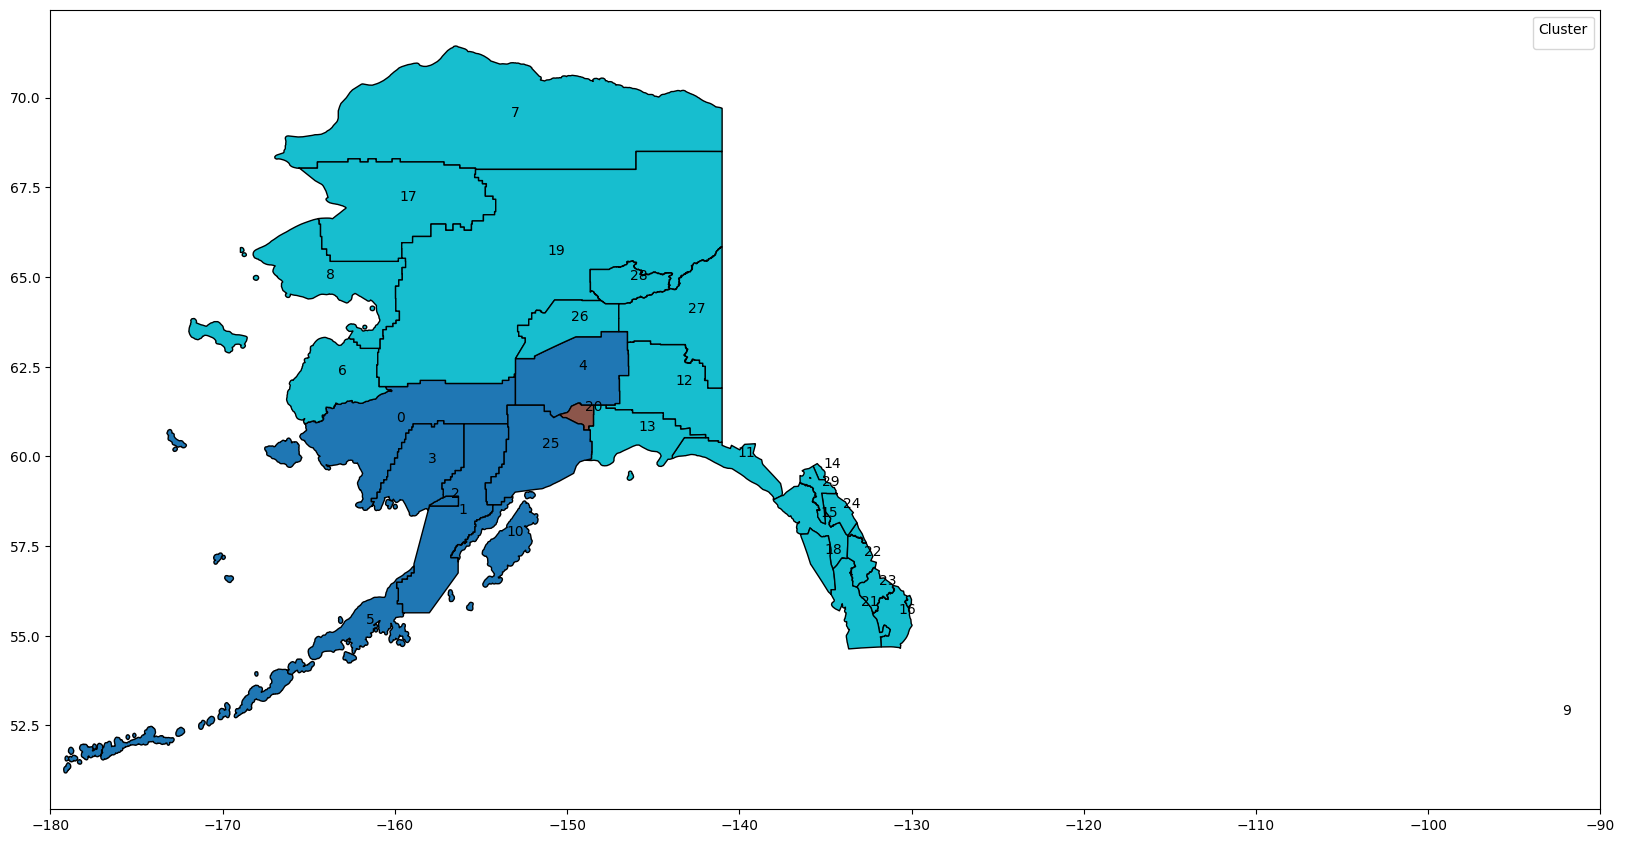

In [ ]:
gdf_counties_or_tracts = gpd.read_file(f"{path_to_shapefile}.shp")
gdf_centers = gpd.read_file(f"{path_to_centers_shapefile}.shp")

gdf_centers['cluster'] = cluster_list
# gdf_centers = gdf_centers.merge(pop_df, left_on='id', right_on='id')
gdf_centers = pd.concat([gdf_centers, pop_df], axis=1, join='inner')
gdf_centers['markersize'] = gdf_centers['pop'].astype(int) / gdf_centers['pop'].astype(int).max() * 500 

# Merge cluster assignments to counties
gdf_counties_or_tracts = gdf_counties_or_tracts.merge(gdf_centers[['GEOID20', 'cluster']], on='GEOID20')

# Plot the counties with colors based on the cluster assignments
fig, ax = plt.subplots(figsize=(20, 30))
gdf_counties_or_tracts.plot(ax=ax, column='cluster', categorical=True, legend=True, edgecolor='black')

# Annotate the plot with the node numbers
for x, y, label in zip(gdf_centers.geometry.x, gdf_centers.geometry.y, gdf_centers.index):
    ax.annotate(label, xy=(x, y), xytext=(3,3), textcoords="offset points")

# Optional: Add legend title
ax.legend(title='Cluster')
ax.set_xlim(-180,-90)

plt.show()